# Spike sorting tutorial 

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from constants import *
from sigutils import *

## Step 1: import the data

https://leicester.figshare.com/articles/dataset/Dataset_Human_single-cell_recording/11302427/1

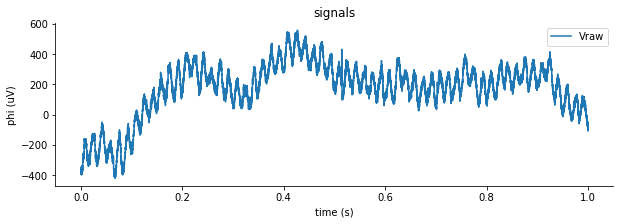

In [3]:
# Define data path
data_file = './data/CSC4.Ncs'
# Load data
data = load_ncs_data(data_file)
# Compute sampling frequency
fs = int(1 / np.diff(data[TIME_S])[0])

# Plot first second of data
fig = plot_signals(data.head(fs))

## Step 2: denoise the data

As we can see the signal has strong 60Hz noise in it. The function below will bandpass filter the signal to exclude the 60Hz domain.

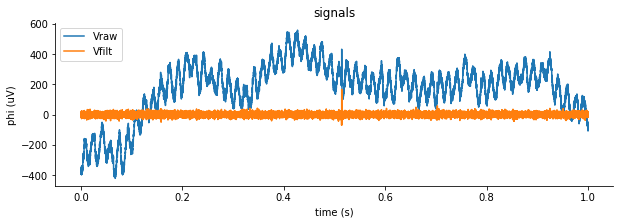

In [4]:
# Filter data between 0.5 and 9 kHz
bounds = [500., 9000]  # Hz
data['Vfilt'] = bandpass_filter(data['Vraw'], fs, bounds)

# Plot first second of data
fig = plot_signals(data.head(fs))

## Extract spikes from the filtered signal

Now that we have a clean spike channel we can identify and extract spikes.

100%|██████████| 10115/10115 [00:03<00:00, 2531.76it/s]


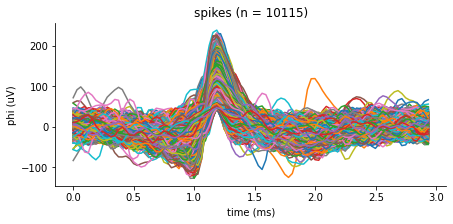

In [23]:
wspike = 3e-3  # s
ispikes, spikes = get_spikes(data['Vfilt'].values, wlen=wspike * fs)
fig = plot_spikes(spikes, fs)

## Reducing the number of dimensions with PCA

To cluster the waveforms we need some features to work with. A feature could be for example the peak amplitude of the spike or the width of the waveform.

Another way to go is to use the principal components of the waveforms. Principal component analysis (PCA) is a dimensionality reduction method which requires normalized data.

Here we will use Scikit Learn for both the normalization and the PCA. We will not go into the details of PCA here since the focus is the clustering.

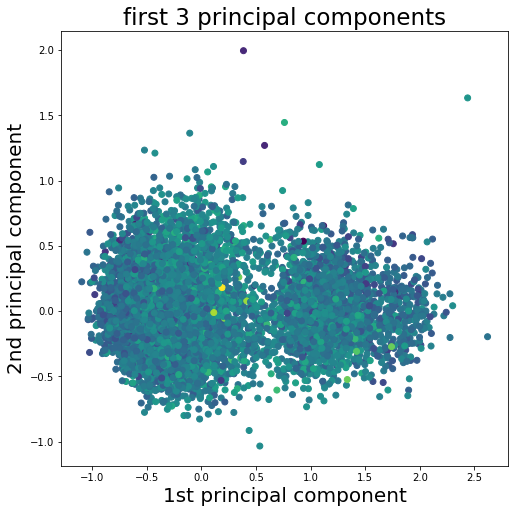

In [26]:
import sklearn as sk
from sklearn.decomposition import PCA

# Apply min-max scaling
scaler= sk.preprocessing.MinMaxScaler()
dataset_scaled = scaler.fit_transform(spikes)

# Do PCA
pca = PCA(n_components=12)
pca_result = pca.fit_transform(dataset_scaled)

# Plot the 1st principal component aginst the 2nd and use the 3rd for color
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(pca_result[:, 0], pca_result[:, 1], c=pca_result[:, 2])
ax.set_xlabel('1st principal component', fontsize=20)
ax.set_ylabel('2nd principal component', fontsize=20)
ax.set_title('first 3 principal components', fontsize=23)

fig.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()

## Clustering with k-means

The way we will implement K-means is quite straight forward.

First, we choose a number of K random datapoints from our sample. These datapoints represent the cluster centers and their number equals the number of clusters.

Next, we will calculate the Euclidean distance between all of the random cluster centers and any other datapoint.

Then we assign each datapoint to the cluster center closest to it.

Obviously doing all of this with random datapoints will not give us a good clustering result. So, we start over again. But this time we don't use random datapoints as cluster centers. Instead we calculate the actual cluster centers based on the previous random assignments and start the process again… and again… and again.

With every iteration the datapoints that switch clusters will go down and we will arrive at a (hopefully) global optimum.